In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
from scipy.special import logit

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/23", start_date=date(2022, 9, 5), end_date=date(2023, 3, 26)
    ),
    SeasonRange(
        season="2023/24", start_date=date(2023, 9, 4), end_date=date(2024, 3, 31)
    ),
    SeasonRange(
        season="2024/25", start_date=date(2024, 9, 2), end_date=date(2025, 3, 30)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=6)

In [5]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age", categories=("adult", "senior", "elderly")
)

In [6]:
params = []

params_grid = {
    "2022/23": {
        "m": 0.3,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.01,
        },
        "senior": {
            "m": 0.1,
        },
        "elderly": {
            "m": 0.25,
        },
    },
    "2023/24": {
        "m": 0.31,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.015,
        },
        "senior": {
            "m": 0.12,
        },
        "elderly": {
            "m": 0.3,
        },
    },
    "2024/25": {
        "m": 0.32,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.02,
        },
        "senior": {
            "m": 0.15,
        },
        "elderly": {
            "m": 0.35,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                if curve_param == "m":
                    param_value = logit(param_value)
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    )
                )

pprint(params)

[('m', '2022/23', 'female', 'adult', -0.8472978603872037),
 ('m', '2022/23', 'female', 'senior', -0.4054651081081643),
 ('m', '2022/23', 'female', 'elderly', 0.20067069546215133),
 ('m', '2022/23', 'male', 'adult', -0.8953840470548413),
 ('m', '2022/23', 'male', 'senior', -0.4473122180436648),
 ('m', '2022/23', 'male', 'elderly', 0.16034265007517953),
 ('m', '2023/24', 'female', 'adult', -0.8001193001121132),
 ('m', '2023/24', 'female', 'senior', -0.28185115214098777),
 ('m', '2023/24', 'female', 'elderly', 0.4473122180436648),
 ('m', '2023/24', 'male', 'adult', -0.871222446472449),
 ('m', '2023/24', 'male', 'senior', -0.34333332700115826),
 ('m', '2023/24', 'male', 'elderly', 0.3846743384390905),
 ('m', '2024/25', 'female', 'adult', -0.7537718023763801),
 ('m', '2024/25', 'female', 'senior', -0.12014431184206335),
 ('m', '2024/25', 'female', 'elderly', 0.7081850579244856),
 ('m', '2024/25', 'male', 'adult', -0.8472978603872037),
 ('m', '2024/25', 'male', 'senior', -0.20067069546215133

In [7]:
observations = sample_dataset(
    logistic_curve, season_ranges, date_ranges, [sex_cov, age_cov], params, 0.0005
)
observations

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value
0,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,1.298835e-02
1,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,1.583821e-02
2,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,2.370654e-02
3,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,1.105091e-02
4,2022/23,2022-09-05,2023-03-26,2022-09-05,2022-09-11,2022-09-11,male,senior,incidence,1.563569e-02
...,...,...,...,...,...,...,...,...,...,...
529,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,senior,incidence,2.265377e-05
530,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,female,elderly,incidence,3.799586e-03
531,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,adult,incidence,3.937500e-43
532,2024/25,2024-09-02,2025-03-30,2025-03-24,2025-03-30,2025-03-30,male,senior,incidence,1.312577e-07


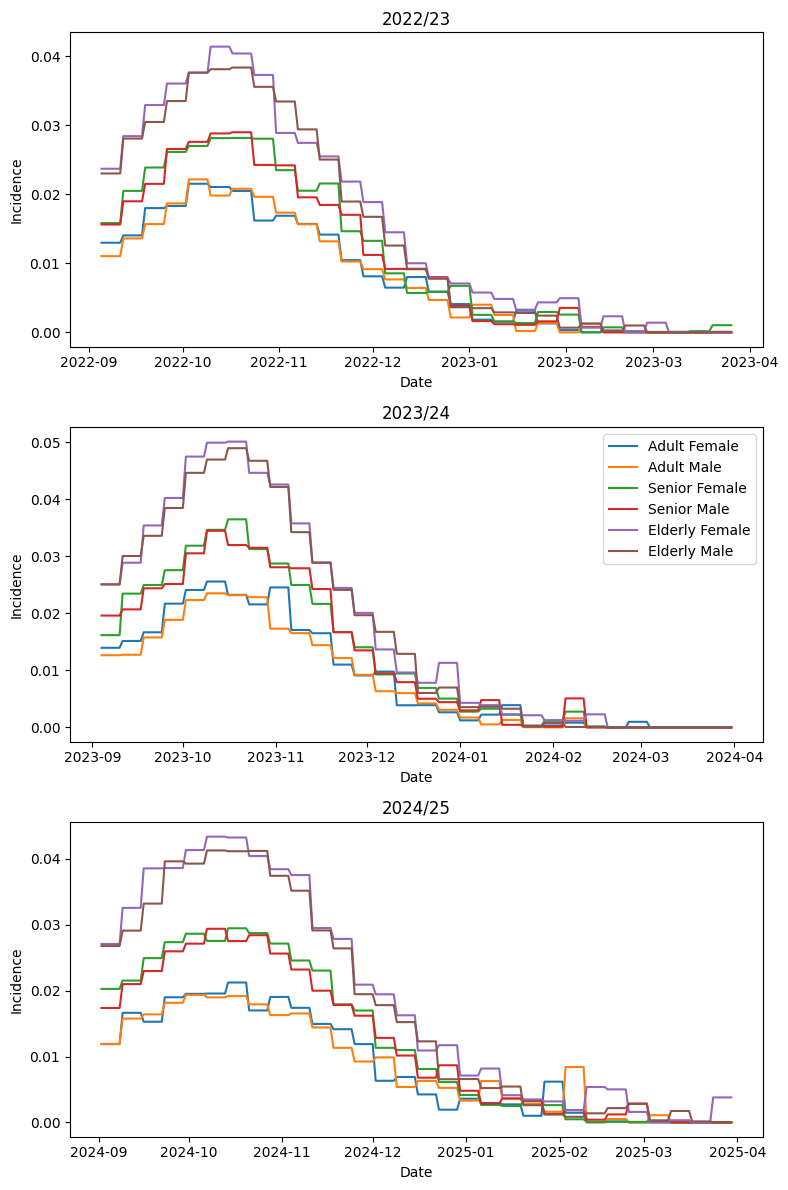

In [8]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [9]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 0.5, "sigma": 0.2},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.5},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 8.0},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.1, 0.2],
            mu=2 * [0.0],
            sigma=2 * [0.2],
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=-0.05,
            mu=0.0,
            sigma=0.2,
        ),
    ],
    observations=observations,
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.001,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=1e-4,
)
model

In [10]:
model.build(debug=True)

INFO: Using 89 date ranges for the uptake model.
INFO: Using 534 observational date ranges for the uptake model.
INFO: Added season 2022/23 to the model with 203 days.
INFO: Added season 2023/24 to the model with 210 days.
INFO: Added season 2024/25 to the model with 210 days.
INFO: Added covariate MSeason to the model with shape [3].
INFO: Added covariate RSeason to the model with shape [3].
INFO: Added covariate SSeason to the model with shape [3].
INFO: Added covariate MAge to the model with shape [3 2].
INFO: Added covariate MSex to the model with shape [3].
INFO: Added summed parameter MSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter MSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202324SexFemaleAgeAdult t

In [11]:
model.sample(
    tune=2000,
    draws=500,
    chains=2,
)

Running window adaptation


There were 990 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


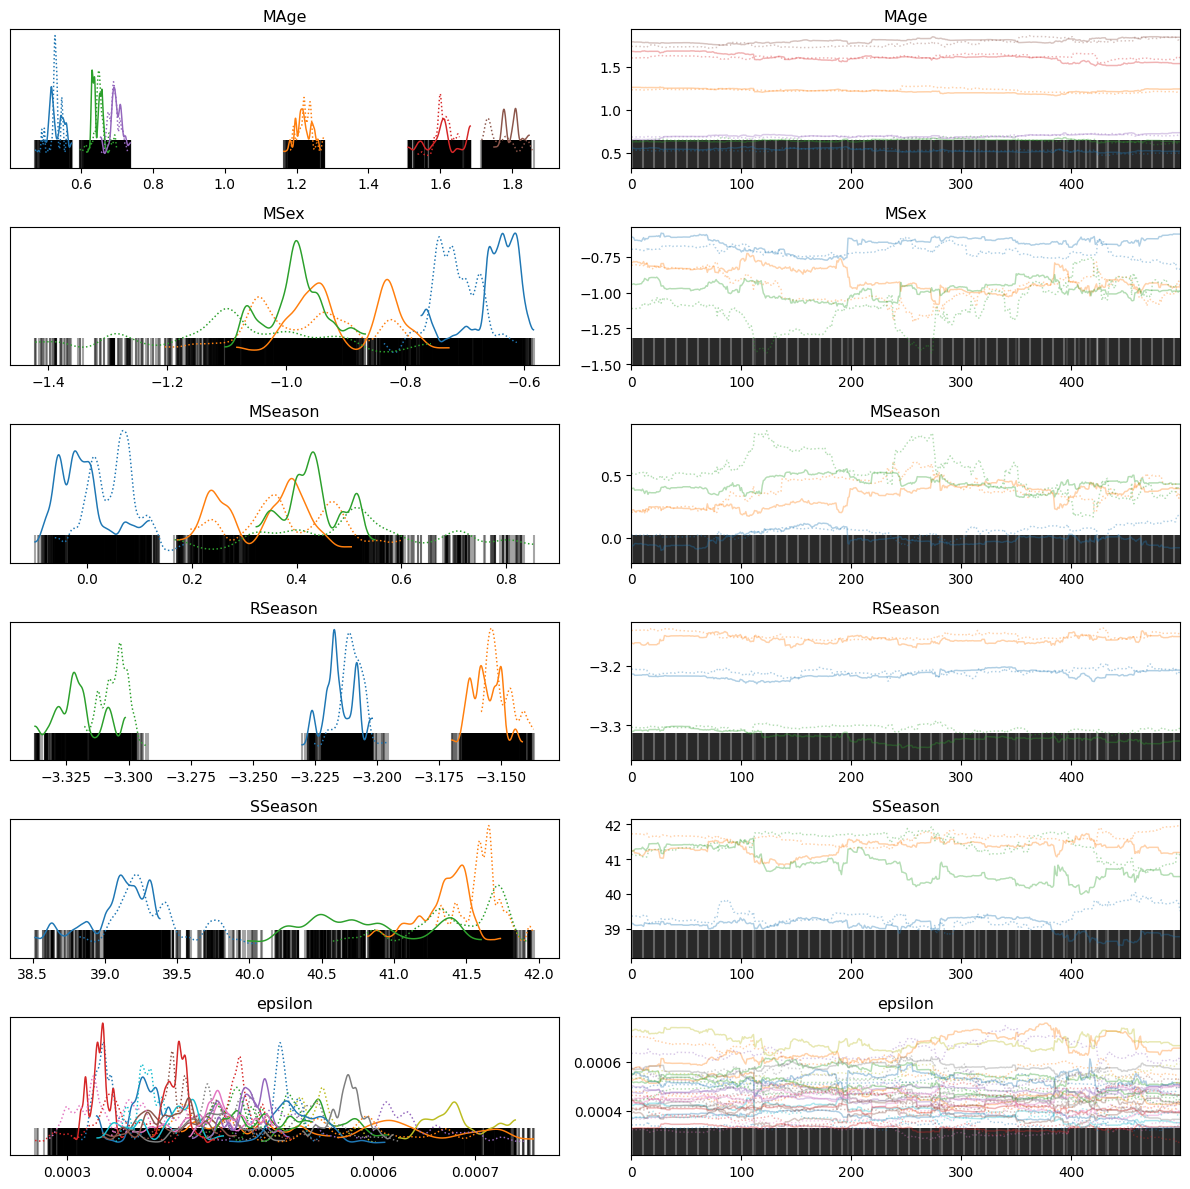

In [12]:
az.plot_trace(
    model._trace, var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"]
)
plt.tight_layout()